In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('ggplot')

import seaborn as sns

import cartopy.crs as ccrs
import cartopy.feature as cfeat
import cartopy.io.img_tiles as cimgt

import AISMapPlot as aismap
from sklearn.neighbors import KNeighborsRegressor

In [2]:
ais_learners = []
sectors = [0, 1, 2]
sector_borders = [2.2, 3.20, 3.94]
positions = pd.DataFrame([[np.nan, 2.2], [np.nan, 3.2], [np.nan, 3.94]],
                         columns = ['Latitude', 'Longitude'])


for s in sectors:
    ais_learners.append(pd.read_pickle('FEL-ROT_learners_01min_s%d.pkl' % (s)))

In [3]:
positions

,Latitude,Longitude
0,NaN,2.20
1,NaN,3.20
2,NaN,3.94


In [36]:
complete= ais_learners[0]
complete= complete.append([ais_learners[1]])
complete= complete.append([ais_learners[2]])

In [19]:
ais_learners[0].head()

,TripID,time,Length,Breadth,Draught,Latitude,Longitude,SOG,COG,TH,...,hour_of_day,weekday,day_of_month,month,sector,mins_to_sector_leave,sector_leave_lat,sector_leave_lon,sector_leave_sog,sector_leave_cog
336698,1000064,2016-03-14 23:40:00,82.0,11.0,3.04,52.03,1.69,8.1,88.0,76.0,...,23,0,14,3,0,136.615385,52.0,2.2,9.130769,99.1
336699,1000064,2016-03-14 23:41:00,82.0,11.0,3.04,52.03,1.70,8.2,88.1,77.0,...,23,0,14,3,0,135.615385,52.0,2.2,9.130769,99.1
336700,1000064,2016-03-14 23:42:00,82.0,11.0,3.04,52.03,1.70,8.3,90.1,78.0,...,23,0,14,3,0,134.615385,52.0,2.2,9.130769,99.1
336701,1000064,2016-03-14 23:43:00,82.0,11.0,3.04,52.03,1.70,8.5,88.7,76.0,...,23,0,14,3,0,133.615385,52.0,2.2,9.130769,99.1
336533,1000064,2016-03-14 23:44:00,82.0,11.0,3.04,52.03,1.71,8.2,87.9,77.0,...,23,0,14,3,0,132.615385,52.0,2.2,9.130769,99.1


In [5]:
X = []
y = []
for s in sectors:
    X.append(ais_learners[s][['Latitude', 'Longitude']])
    y.append(ais_learners[s][['sector_leave_lat', 'sector_leave_lon', 'mins_to_sector_leave']])

In [6]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_score

cv_splits = []
for s in sectors:
    cv_splits.append(list(GroupKFold(n_splits = 10).split(X[s], y[s], groups = ais_learners[s]['TripID'])))

In [7]:
# Retrieve ONE simple train-test split (for each sector)
train_indices = []
test_indices = []
for s in sectors:
    a, b = cv_splits[s][0]
    train_indices.append(a)
    test_indices.append(b)

X_train = []
X_test = []
for s in sectors:
    X_train.append(X[s].iloc[train_indices[s]])
    X_test.append(X[s].iloc[test_indices[s]])

y_train = []
y_test = []
for s in sectors:
    y_train.append(y[s].iloc[train_indices[s]])
    y_test.append(y[s].iloc[test_indices[s]])

In [8]:

'''
for s in sectors:
    knn_pos = KNeighborsRegressor(n_neighbors = 20)
    scores = cross_val_score(knn_pos, X[s], y[s], cv = cv_splits[s], scoring = 'neg_mean_absolute_error')
    print(scores.mean())'''

"\nfor s in sectors:\n    knn_pos = KNeighborsRegressor(n_neighbors = 20)\n    scores = cross_val_score(knn_pos, X[s], y[s], cv = cv_splits[s], scoring = 'neg_mean_absolute_error')\n    print(scores.mean())"

In [9]:
knn_pos_list = []
for s in sectors:
    knn_pos = KNeighborsRegressor(n_neighbors = 20)
    if s == 0:
        knn_pos.fit(X_train[s], y_train[s]['sector_leave_lon'])
    else:
        knn_pos.fit(X_train[s], y_train[s]['sector_leave_lat'])
    knn_pos_list.append(knn_pos)

In [10]:
knn_pos_list[2].predict([[53.99, 8.17]])

array([ 52.01])

In [28]:
# 51.99 4.07
lats = [52.03]
lons = [1.70]
for s in sectors:
    if s == 0:
        lon = sector_borders[0]
        lat = knn_pos_list[1].predict([[lats[-1], lons[-1]]])[0]
    else:
        lat = knn_pos_list[s].predict([[lats[-1], lons[-1]]])[0]
        lon = sector_borders[s]
    lats.append(lat)
    lons.append(lon)
print(lats)
print(lons)

[52.03, 52.097999999999992, 52.283500000000004, 52.010000000000005]
[1.7, 2.2, 3.2, 3.94]


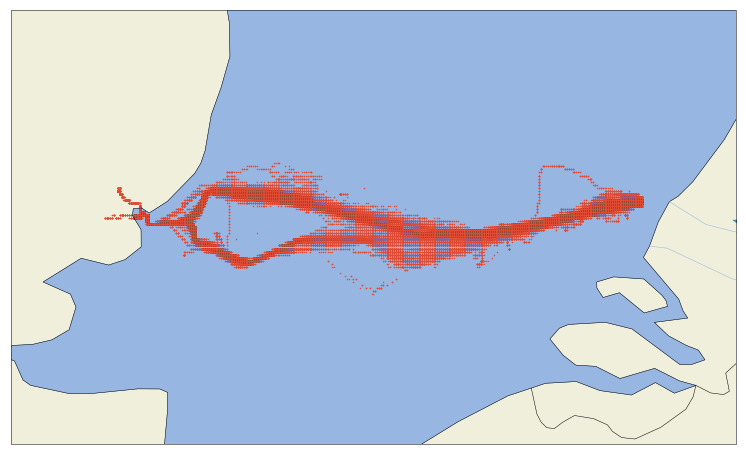

In [37]:
aismap.plot_to_map(size = (13, 13), longitude = complete['Longitude'], latitude = complete['Latitude'])

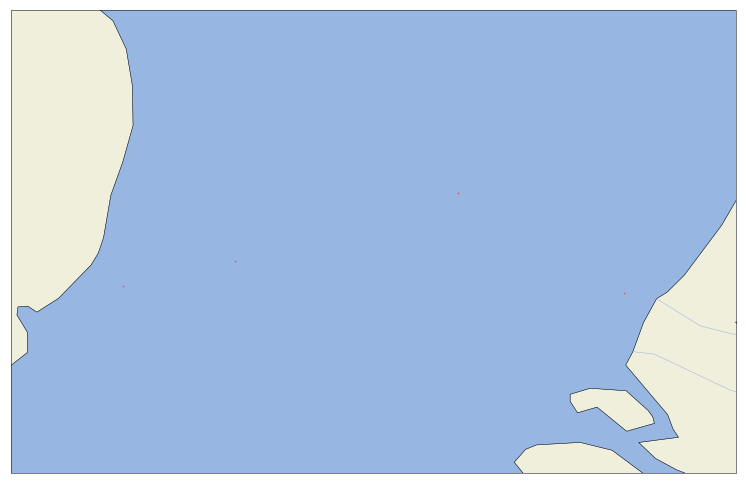

In [29]:
aismap.plot_to_map(size = (13, 13), longitude = pd.Series(lons), latitude = pd.Series(lats))

In [13]:
for s in sectors:
    knn_time = KNeighborsRegressor(n_neighbors = 20)
    scores = cross_val_score(knn_time, X[s], y[s]['mins_to_sector_leave'], cv = cv_splits[s], scoring = 'neg_mean_absolute_error')
    print("%d -> %f" % (s, scores.mean()))

0 -> -14.120533
1 -> -15.801908
2 -> -13.466343


In [14]:
knn_time_list = []
for s in sectors:
    knn_time = KNeighborsRegressor(n_neighbors = 20)
    knn_time.fit(X_train[s], y_train[s]['mins_to_sector_leave'])
    knn_time_list.append(knn_time)

In [54]:
knn_time_list[0].predict([[52.03, 1.70]])[0]

76.360901712678341

In [50]:
# Pickle KNN models
import pickle

for s in sectors:
    pos_model = knn_pos_list[s]
    pickle.dump(pos_model, open('../App/Agents/fel_rot_s%d/model_position.pkl' % (s), 'wb'))
    
    time_model = knn_time_list[s]
    pickle.dump(time_model, open('../App/Agents/fel_rot_s%d/model_time.pkl' % (s), 'wb'))

In [58]:
test_loaded = pickle.load(open('../App/Agents/fel_rot_s%d/model_time.pkl' % (2), 'rb'))
test_loaded.predict([[52.03, 1.7]])[2]

IndexError: index 2 is out of bounds for axis 0 with size 1

In [56]:
print(knn_time_list[2])
print(test_loaded)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=20, p=2,
          weights='uniform')
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=20, p=2,
          weights='uniform')
